# Réplication Simulations TVA - Budget 2025 : Chapitre socio-fiscal

In [ ]:
import numpy as np
import pandas as pd
import os
import csv
import ast
import seaborn as sns
from matplotlib import pyplot as plt
import wquantiles 

from tqdm import tqdm
from wquantiles import quantile
from openfisca_survey_manager.utils import asof

from openfisca_france_indirect_taxation import FranceIndirectTaxationTaxBenefitSystem
from openfisca_france_indirect_taxation.surveys import SurveyScenario
from openfisca_france_indirect_taxation.utils import assets_directory, get_input_data_frame
from openfisca_france_indirect_taxation.examples.utils_example import (
    dataframe_by_group,
    df_weighted_average_grouped,
    wavg)
from openfisca_france_indirect_taxation.build_survey_data.utils import weighted_sum
from openfisca_france_indirect_taxation.Calage_consommation_bdf import new_get_inflators_by_year
from openfisca_france_indirect_taxation.Calage_revenus_bdf import calage_bdf_niveau_vie
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import weighted_quantiles, stacked_bar_plot, double_stacked_bar_plot, bootstrap_weighted_mean_by_decile
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Reform_TVA_budget_2025 import augmente_tous_les_taux

In [2]:
simulated_variables = ['depenses_tva_taux_plein',
'depenses_tva_taux_intermediaire',
'depenses_tva_taux_reduit',
'depenses_tva_taux_super_reduit',
'depenses_ht_tva_taux_plein',
'depenses_ht_tva_taux_intermediaire',
'depenses_ht_tva_taux_reduit',
'depenses_ht_tva_taux_super_reduit',
'depenses_tva_exonere',
'depenses_totales',
'depenses_tot',
'tva_total',
'rev_disponible',
 'niveau_de_vie',
 'niveau_vie_decile',
 'decile_indiv_niveau_vie',
 'ocde10',
 'pondmen',
 'pondindiv',
 'nactifs',
 'npers',
 'identifiant_menage']

## Calage sur les niveaux de vie dans TaxIPP

In [3]:
data = {"decile_indiv_niveau_vie": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'rev_disponible_taxipp' : [
        17164,
        28523,
        32785,
        37962,
        42484,
        47179,
        53571,
        60538,
        72271,
        121762,
    ],
    'niveau_de_vie' : [
        8082,
        14242,
        17617,
        20598,
        23339,
        26229,
        29506,
        33734,
        40382,
        69374
    ]
}
decile_taxipp = pd.DataFrame(data)
decile_taxipp.set_index('decile_indiv_niveau_vie', inplace = True)

In [4]:
input_bdf = get_input_data_frame(2017)
input_bdf = input_bdf.loc[input_bdf['rev_disponible'] > 0]
input_bdf , df_calage = calage_bdf_niveau_vie(input_bdf, decile_taxipp)

In [5]:
year = 2024
data_year = 2017
tax_benefit_system = FranceIndirectTaxationTaxBenefitSystem()
inflators_by_year = new_get_inflators_by_year(rebuild = False, year_range = range(2017, 2025), data_year = data_year)
inflation_kwargs = dict(inflator_by_variable = inflators_by_year[year])

survey_scenario = SurveyScenario.create(
    input_data_frame = input_bdf,        # on prend la base Bdf avec les revenus calées sur TaxIPP comme entrée pour la simulation
    inflation_kwargs =  inflation_kwargs,
    baseline_tax_benefit_system = tax_benefit_system,
    reform = augmente_tous_les_taux,
    year = year,
    )

c:\Users\veve1\miniconda3\envs\openfiscaenv\lib\site-packages\openfisca_core\holders\holder.py:230: Warning: You cannot set a value for the variable poste_09_6_1_2, as it has been neutralized. The value you provided ([0. 0. 0. ... 0. 0. 0.]) will be ignored.
  return warnings.warn(


## Recalage sur les 13 Milliards

On recale également les dépenses pour atteindre un montant de dépenses hors-taxes de 60,5% de 1 300 Milliards. De sorte que le rendement du point de TVA soit de 13 Milliards

In [6]:
depenses_ht_totales = (survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_plein', use_baseline = True, period = year) +
 survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_intermediaire', use_baseline = True, period = year) + 
 survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_reduit', use_baseline = True, period = year) + 
 survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_super_reduit', use_baseline = True, period = year)
 )
depenses_ht_totales
tva_total = survey_scenario.compute_aggregate(variable = 'tva_total', use_baseline = True, period = year)
emplois_taxables_tot = 13E11
part_conso_menages = 0.605
coeff = part_conso_menages * emplois_taxables_tot / depenses_ht_totales
coeff

0.8843191782330855

In [7]:
new_inflators_2024 = { k:v if k in ['loyer_impute','rev_disponible'] else  v*coeff 
                      for k,v in inflators_by_year[2024].items()}
inflation_kwargs = dict(inflator_by_variable = new_inflators_2024)

survey_scenario = SurveyScenario.create(
    input_data_frame = input_bdf,        # on prend la base Bdf avec les revenus calées sur TaxIPP comme entrée pour la simulation
    inflation_kwargs =  inflation_kwargs,
    baseline_tax_benefit_system = tax_benefit_system,
    reform = augmente_tous_les_taux,
    year = year,
    )

In [8]:
recolte_taux_plein = survey_scenario.compute_aggregate(variable='tva_taux_plein', filter_by = 'rev_disponible > 0', difference= True, period = year) * 1e-9
recolte_taux_inter = survey_scenario.compute_aggregate(variable='tva_taux_intermediaire', filter_by = 'rev_disponible > 0', difference= True, period = year) * 1e-9
recolte_taux_reduit = survey_scenario.compute_aggregate(variable='tva_taux_reduit', filter_by = 'rev_disponible > 0', difference= True, period = year) * 1e-9
recolte_taux_super_reduit = survey_scenario.compute_aggregate(variable='tva_taux_super_reduit', filter_by = 'rev_disponible > 0', difference= True, period = year) * 1e-9
recolte_taux_plein + recolte_taux_inter + recolte_taux_reduit + recolte_taux_super_reduit

7.86499513240386

In [9]:
survey_scenario.compute_aggregate(variable ='tva_total', filter_by = 'rev_disponible > 0', use_baseline= True, period = year) * 1e-9

108.61847590252741

In [10]:
baseline_menage = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', use_baseline = True, period = 2024)['menage']
reform_menage   = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', use_baseline = False, period = 2024)['menage']

In [11]:
difference_menage = pd.DataFrame()
baseline_variables = ['depenses_tot','rev_disponible','niveau_de_vie','decile_indiv_niveau_vie','ocde10','pondmen','nactifs','npers','identifiant_menage'] 
difference_menage[baseline_variables] = baseline_menage[baseline_variables]

difference_menage['depenses_totales'] = baseline_menage['depenses_totales'] - reform_menage['depenses_totales']
difference_menage['depenses_tot_par_uc'] = difference_menage['depenses_tot'] / difference_menage['ocde10']
difference_menage['depenses_totales_par_uc'] = difference_menage['depenses_totales'] / difference_menage['ocde10']

for taux in ['plein','intermediaire', 'reduit', 'super_reduit']:
    difference_menage['depenses_tva_taux_{}'.format(taux)] = baseline_menage['depenses_tva_taux_{}'.format(taux)] - reform_menage['depenses_tva_taux_{}'.format(taux)] 
difference_menage['actifs'] = (difference_menage['nactifs'] >= 1)

difference_menage['pondindiv'] = difference_menage['pondmen'] * difference_menage['npers']

### Les effets d'une hausse de TVA par décile de niveau de vie

In [68]:
liste_taux = ['plein','intermediaire', 'reduit', 'super_reduit']
for taux in liste_taux:
   difference_menage['depenses_par_uc_tva_taux_{}'.format(taux)] = difference_menage['depenses_tva_taux_{}'.format(taux)] / difference_menage['ocde10']

difference_by_decile = df_weighted_average_grouped(dataframe = difference_menage, 
                                                   groupe = 'decile_indiv_niveau_vie', 
                                                   varlist = ['depenses_tot','depenses_tot_par_uc','depenses_totales_par_uc',
                                                              'rev_disponible','niveau_de_vie'] +
                                                   ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux],
                                                   weights = 'pondindiv'
                                                    )

In [69]:
difference_by_decile['taux_epargne'] = 1 - difference_by_decile['depenses_tot'] / difference_by_decile['rev_disponible']
difference_by_decile

,depenses_tot,depenses_tot_par_uc,depenses_totales_par_uc,rev_disponible,niveau_de_vie,depenses_par_uc_tva_taux_plein,depenses_par_uc_tva_taux_intermediaire,depenses_par_uc_tva_taux_reduit,depenses_par_uc_tva_taux_super_reduit,taux_epargne
decile_indiv_niveau_vie,,,,,,,,,,
1,28410.790772,15316.755639,-103.793649,15914.199155,8081.976145,-54.562802,-16.012703,-32.422897,-0.795243,-0.785248
2,31821.178981,16911.702692,-116.663711,27495.698537,14242.010415,-63.564076,-16.476229,-35.332054,-1.291372,-0.157315
3,33975.673738,18790.187387,-128.336941,32230.631635,17616.995260,-70.045011,-19.260974,-37.747354,-1.283612,-0.054142
4,38963.268266,21467.496802,-147.411631,37637.690013,20598.009689,-80.067674,-22.088548,-43.711504,-1.543824,-0.035219
5,41792.131772,23334.619763,-163.629653,42196.219971,23338.995867,-85.864874,-30.730495,-45.146197,-1.888109,0.009576
6,48255.997814,26587.330589,-191.128870,47299.487400,26229.003131,-91.893311,-47.134700,-50.103497,-1.997329,-0.020222
7,47071.033102,26230.562972,-187.852025,53242.761623,29505.999412,-100.038603,-33.312654,-52.681066,-1.819741,0.115917
8,53739.332496,30034.833409,-218.994294,60469.961218,33734.011222,-111.293862,-43.506157,-62.006900,-2.187356,0.111305
9,57660.665302,32306.836103,-238.097866,72112.938797,40382.025551,-121.092456,-50.284820,-63.932980,-2.787565,0.200412


In [70]:
for taux in liste_taux:
   difference_by_decile['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_decile['depenses_par_uc_tva_taux_{}'.format(taux)] / difference_by_decile['niveau_de_vie'] * 100
difference_by_decile['Taux_effort_total'] = difference_by_decile['depenses_totales_par_uc'] / difference_by_decile['niveau_de_vie'] * 100

In [71]:
df = difference_menage.copy()
results_bootstrap_all = bootstrap_weighted_mean_by_decile(df, 'pondindiv', 'decile_indiv_niveau_vie', B = 10000)

  1%|          | 104/10000 [00:05<08:22, 19.68it/s]


KeyboardInterrupt: 

In [72]:
errors_all = pd.DataFrame(pd.DataFrame(results_bootstrap_all).std(axis = 0))
errors_all = errors_all.reset_index().drop('index',axis = 1).rename({0 : 'std'},axis = 1)
errors_all = errors_all.reset_index().rename({'index' : 'decile_indiv_niveau_vie'}, axis = 1).set_index('decile_indiv_niveau_vie')
errors_all.index = errors_all.index + 1
errors_all['errors'] = 1.96 * errors_all['std']
difference_by_decile = difference_by_decile.merge(errors_all, left_index = True, right_index = True)

In [26]:
bottom_50 = pd.DataFrame(difference_by_decile.loc[difference_by_decile.index < 6, ['depenses_totales_par_uc','niveau_de_vie','Taux_effort_total']].mean(axis = 0)).T
bottom_50['taux_effort_moyen'] = bottom_50['depenses_totales_par_uc'] / bottom_50['niveau_de_vie'] * 100
bottom_50

,depenses_totales_par_uc,niveau_de_vie,Taux_effort_total,taux_effort_moyen
0,-131.967117,16775.597475,-0.849731,-0.786661


In [27]:
difference_by_decile.loc[difference_by_decile.index.isin([6,7,8,9]), ['depenses_totales_par_uc','niveau_de_vie','Taux_effort_total']]

,depenses_totales_par_uc,niveau_de_vie,Taux_effort_total
decile_indiv_niveau_vie,,,
6,-191.128870,26229.003131,-0.728693
7,-187.852025,29505.999412,-0.636657
8,-218.994294,33734.011222,-0.649180
9,-238.097866,40382.025551,-0.589613


In [28]:
middle_40 = pd.DataFrame(difference_by_decile.loc[difference_by_decile.index.isin([6,7,8,9]), ['depenses_totales_par_uc','niveau_de_vie','Taux_effort_total']].mean(axis = 0)).T
middle_40['taux_effort_moyen'] = middle_40['depenses_totales_par_uc'] / middle_40['niveau_de_vie'] * 100
middle_40

,depenses_totales_par_uc,niveau_de_vie,Taux_effort_total,taux_effort_moyen
0,-209.018264,32462.759829,-0.651036,-0.643871


In [73]:
difference_by_decile

,depenses_tot,depenses_tot_par_uc,depenses_totales_par_uc,rev_disponible,niveau_de_vie,depenses_par_uc_tva_taux_plein,depenses_par_uc_tva_taux_intermediaire,depenses_par_uc_tva_taux_reduit,depenses_par_uc_tva_taux_super_reduit,taux_epargne,Taux_effort_tva_taux_plein,Taux_effort_tva_taux_intermediaire,Taux_effort_tva_taux_reduit,Taux_effort_tva_taux_super_reduit,Taux_effort_total,std,errors
decile_indiv_niveau_vie,,,,,,,,,,,,,,,,,
1,28410.790772,15316.755639,-103.793649,15914.199155,8081.976145,-54.562802,-16.012703,-32.422897,-0.795243,-0.785248,-0.675117,-0.198129,-0.401175,-0.009840,-1.284261,0.075720,0.148411
2,31821.178981,16911.702692,-116.663711,27495.698537,14242.010415,-63.564076,-16.476229,-35.332054,-1.291372,-0.157315,-0.446314,-0.115688,-0.248083,-0.009067,-0.819152,0.042045,0.082407
3,33975.673738,18790.187387,-128.336941,32230.631635,17616.995260,-70.045011,-19.260974,-37.747354,-1.283612,-0.054142,-0.397599,-0.109332,-0.214267,-0.007286,-0.728484,0.040023,0.078446
4,38963.268266,21467.496802,-147.411631,37637.690013,20598.009689,-80.067674,-22.088548,-43.711504,-1.543824,-0.035219,-0.388716,-0.107236,-0.212212,-0.007495,-0.715660,0.040283,0.078954
5,41792.131772,23334.619763,-163.629653,42196.219971,23338.995867,-85.864874,-30.730495,-45.146197,-1.888109,0.009576,-0.367903,-0.131670,-0.193437,-0.008090,-0.701100,0.041654,0.081641
6,48255.997814,26587.330589,-191.128870,47299.487400,26229.003131,-91.893311,-47.134700,-50.103497,-1.997329,-0.020222,-0.350350,-0.179705,-0.191023,-0.007615,-0.728693,0.057065,0.111848
7,47071.033102,26230.562972,-187.852025,53242.761623,29505.999412,-100.038603,-33.312654,-52.681066,-1.819741,0.115917,-0.339045,-0.112901,-0.178544,-0.006167,-0.636657,0.025266,0.049522
8,53739.332496,30034.833409,-218.994294,60469.961218,33734.011222,-111.293862,-43.506157,-62.006900,-2.187356,0.111305,-0.329916,-0.128968,-0.183811,-0.006484,-0.649180,0.031320,0.061386
9,57660.665302,32306.836103,-238.097866,72112.938797,40382.025551,-121.092456,-50.284820,-63.932980,-2.787565,0.200412,-0.299867,-0.124523,-0.158320,-0.006903,-0.589613,0.024217,0.047465


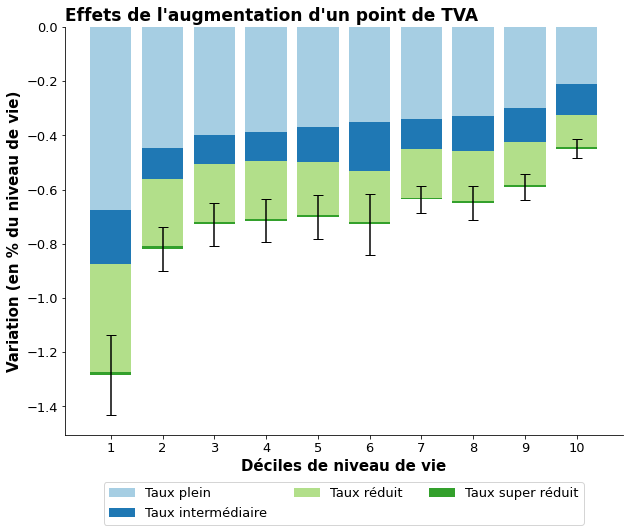

In [74]:
stacked_bar_plot(difference_by_decile, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = False,
                 outfile = 'Taux_effort.pdf',
                 errors = 'errors'
                 )

#### Décomposition actifs / inactifs

In [75]:
difference_by_decile_actifs = df_weighted_average_grouped(dataframe = difference_menage.loc[difference_menage['actifs'] == 1], 
                                                   groupe = 'decile_indiv_niveau_vie', 
                                                   varlist = ['depenses_tot','depenses_tot_par_uc','depenses_totales_par_uc',
                                                              'rev_disponible','niveau_de_vie'] +
                                                   ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux],
                                                   weights = 'pondindiv'
                                                    )
difference_by_decile_actifs['taux_epargne_actifs'] = 1 - difference_by_decile_actifs['depenses_tot'] / difference_by_decile_actifs['rev_disponible']

In [76]:
difference_by_decile_actifs[['taux_epargne_actifs']]

,taux_epargne_actifs
decile_indiv_niveau_vie,
1,-0.776282
2,-0.173091
3,-0.068315
4,-0.034036
5,0.002503
6,-0.053288
7,0.112044
8,0.105466
9,0.184274


In [77]:
for taux in liste_taux:
   difference_by_decile_actifs['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_decile_actifs['depenses_par_uc_tva_taux_{}'.format(taux)] / difference_by_decile_actifs['niveau_de_vie'] * 100
difference_by_decile_actifs['Taux_effort_total'] = difference_by_decile_actifs['depenses_totales_par_uc'] / difference_by_decile_actifs['niveau_de_vie'] * 100

In [78]:
# Bootstrap 

results_bootstrap_actifs = bootstrap_weighted_mean_by_decile(df.loc[df['actifs'] == 1], 'pondindiv', 'decile_indiv_niveau_vie', B = 1000)
errors_actifs = pd.DataFrame(pd.DataFrame(results_bootstrap_actifs).std(axis = 0))
errors_actifs = errors_actifs.reset_index().drop('index',axis = 1).rename({0 : 'std'},axis = 1)
errors_actifs = errors_actifs.reset_index().rename({'index' : 'decile_indiv_niveau_vie'}, axis = 1).set_index('decile_indiv_niveau_vie')
errors_actifs.index = errors_actifs.index + 1
errors_actifs['errors'] = 1.96 * errors_actifs['std']
difference_by_decile_actifs = difference_by_decile_actifs.merge(errors_actifs, left_index = True, right_index = True)

100%|██████████| 1000/1000 [00:41<00:00, 24.26it/s]


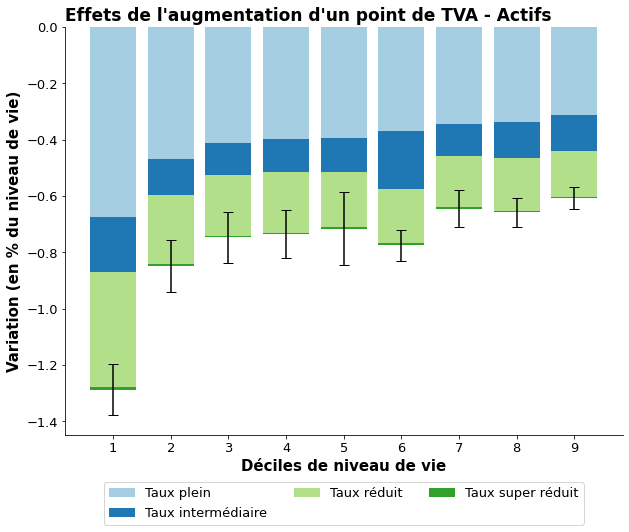

In [42]:
stacked_bar_plot(difference_by_decile_actifs, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA - Actifs",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = False,
                 outfile = 'Taux_effort_actifs_only.pdf',
                 errors = 'errors')

In [80]:
difference_by_decile_not_actifs = df_weighted_average_grouped(dataframe = difference_menage.loc[difference_menage['actifs'] == 0], 
                                                   groupe = 'decile_indiv_niveau_vie', 
                                                   varlist = ['depenses_tot','depenses_tot_par_uc','depenses_totales_par_uc',
                                                              'rev_disponible','niveau_de_vie'] +
                                                   ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux],
                                                   weights= 'pondindiv'
                                                    )
difference_by_decile_not_actifs['taux_epargne_inactifs'] = 1 - difference_by_decile_not_actifs['depenses_tot'] / difference_by_decile_not_actifs['rev_disponible']

In [81]:
difference_by_decile_not_actifs[['taux_epargne_inactifs']]

,taux_epargne_inactifs
decile_indiv_niveau_vie,
1,-0.819678
2,-0.089000
3,0.003540
4,-0.040509
5,0.041517
6,0.135445
7,0.137193
8,0.141952
9,0.291923


In [82]:
for taux in liste_taux:
   difference_by_decile_not_actifs['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_decile_not_actifs['depenses_par_uc_tva_taux_{}'.format(taux)] / difference_by_decile_not_actifs['niveau_de_vie'] * 100
difference_by_decile_not_actifs['Taux_effort_total'] = difference_by_decile_not_actifs['depenses_totales_par_uc'] / difference_by_decile_not_actifs['niveau_de_vie'] * 100

In [83]:
# Bootstrap 

results_bootstrap_inactifs = bootstrap_weighted_mean_by_decile(df.loc[df['actifs'] == 0], 'pondindiv', 'decile_indiv_niveau_vie', B = 1000)
errors_inactifs = pd.DataFrame(pd.DataFrame(results_bootstrap_inactifs).std(axis = 0))
errors_inactifs = errors_inactifs.reset_index().drop('index',axis = 1).rename({0 : 'std'},axis = 1)
errors_inactifs = errors_inactifs.reset_index().rename({'index' : 'decile_indiv_niveau_vie'}, axis = 1).set_index('decile_indiv_niveau_vie')
errors_inactifs.index = errors_inactifs.index + 1
errors_inactifs['errors'] = 1.96 * errors_inactifs['std']
difference_by_decile_not_actifs = difference_by_decile_not_actifs.merge(errors_inactifs, left_index = True, right_index = True)

100%|██████████| 1000/1000 [00:31<00:00, 31.79it/s]


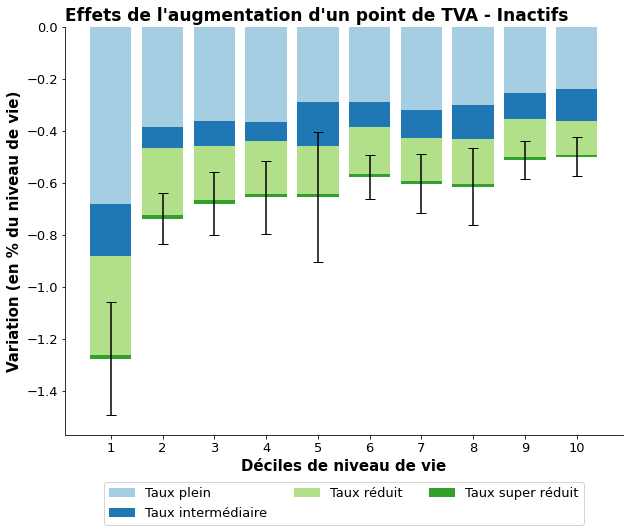

In [84]:
stacked_bar_plot(difference_by_decile_not_actifs, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA - Inactifs",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = False,
                 outfile = 'Taux_effort_not_actifs.pdf',
                 errors = 'errors')

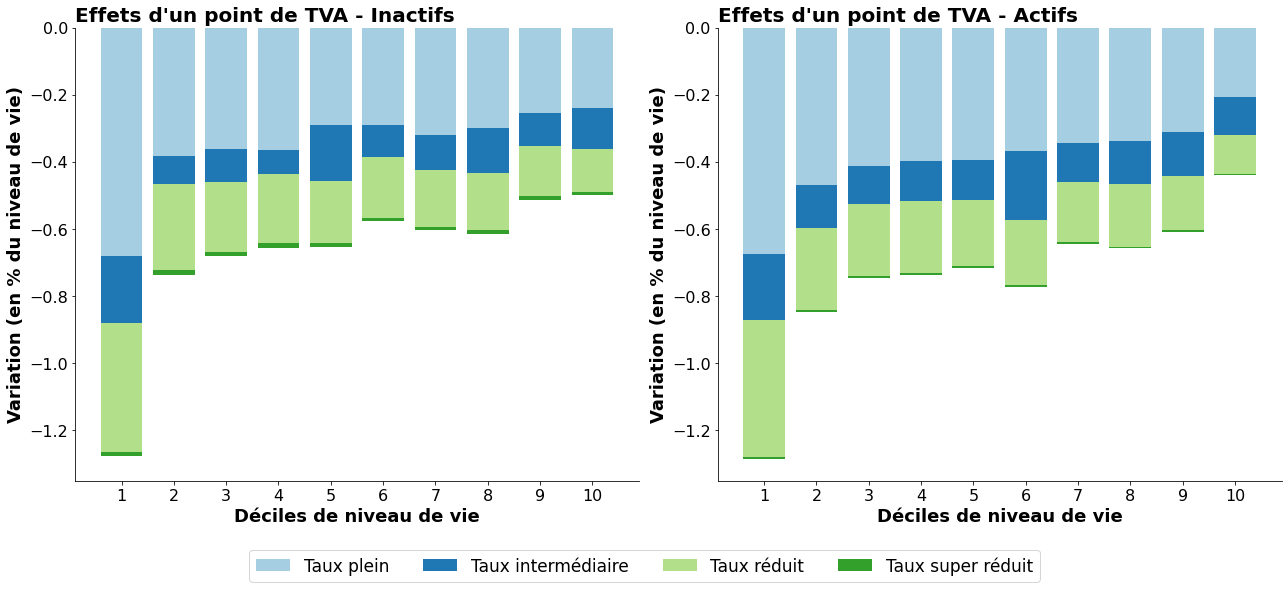

In [85]:
double_stacked_bar_plot(difference_by_decile_not_actifs,
                        difference_by_decile_actifs, 
                        variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                        labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                        title1 = "Effets d'un point de TVA - Inactifs",
                        title2 = "Effets d'un point de TVA - Actifs",
                        xlabel = 'Déciles de niveau de vie' ,
                        ylabel = 'Variation (en % du niveau de vie)',
                        colors = list(sns.color_palette("Paired")),
                        savefig = False,
                        outfile = 'Taux_effort_actifs_not_actifs.pdf')